<h3 style='color:white'>President Image Classification</h3>

In [1]:
import numpy as np
import cv2 #computer vision library
import matplotlib
from matplotlib import pyplot as plt #to show picture
%matplotlib inline 
#renders the figure in notebook

#### preprocessing: detect face and eyes
- once a face is detected, we will detect eyes.
- if two eyes are detected then we keep the image, otherwise we discard it
- using haar cascade from opencv for this
https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html

If you want to train your own classifier for any object like car, planes, etc. you can use OpenCV to create one. Its full details are given here: https://docs.opencv.org/2.4/doc/user_guide/ug_traincascade.html
Here we deal with detection since OpenCV already contains many pre-trained classifiers for face, eyes, smile, etc. First load the required XML classifiers. Then load our input image (or video) in grayscale mode.

In [2]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

#### Crop the facial region of the image
#### Use wavelet transofrm as a feature for training the model
In a wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips, etc

In [3]:
import pywt
#basically creates the image in black and white
def w2d(img, mode='haar', level=1):
    imArray = img
    print(imArray)
    #Datatype conversions from img to array
    #convert to grayscale
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY) #cvtColor converts an image from one color space to another
    #convert to float
    imArray = np.float32(imArray)
    imArray /= 255
    #compute coefficients
    coeffs = pywt.wavedec2(imArray, mode, level=level) #returns wavelet decomposition of the matrix imArray at level mode using the name level

    #process coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0

    #reconstruction
    imArray_H=pywt.waverec2(coeffs_H,mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    return imArray_H

#### Load image, detect face. If eyes >= 2, then save and crop the face region

In [4]:
# takes input image and returns cropped image (if eyes >= 2 and a face are detected)
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #numbers are reject levels and level weights
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [5]:
path_to_data = "./images/"
path_to_cr_data = "./images/cropped/"

In [7]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
#this should create within the cropped directory another directory for each president

In [8]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [9]:
cropped_image_dirs = []
president_file_names_dict = {}
for img_dir in img_dirs:
    if img_dir == "./images/cropped":
        continue
    count = 1
    president_name = img_dir.split('/')[-1]
    president_file_names_dict[president_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + president_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ", cropped_folder)
            cropped_file_name = president_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            president_file_names_dict[president_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./images/cropped/barack_obama
Generating cropped images in folder:  ./images/cropped/bill_clinton
Generating cropped images in folder:  ./images/cropped/joe_biden
Generating cropped images in folder:  ./images/cropped/donald_trump
Generating cropped images in folder:  ./images/cropped/george_w_bush


Now we should have cropped folders under the images folder that contain the cropped images...
#### We must manually examine the cropped folders and delete any unwanted images

In [16]:
president_file_names_dict = {}
for img_dir in cropped_image_dirs:
    president_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        if not entry.path.endswith('.DS_Store'):
            file_list.append(entry.path)
        president_file_names_dict[president_name] = file_list
president_file_names_dict

{'barack_obama': ['./images/cropped/barack_obama/barack_obama4.png',
  './images/cropped/barack_obama/barack_obama17.png',
  './images/cropped/barack_obama/barack_obama16.png',
  './images/cropped/barack_obama/barack_obama14.png',
  './images/cropped/barack_obama/barack_obama7.png',
  './images/cropped/barack_obama/barack_obama28.png',
  './images/cropped/barack_obama/barack_obama29.png',
  './images/cropped/barack_obama/barack_obama6.png',
  './images/cropped/barack_obama/barack_obama15.png',
  './images/cropped/barack_obama/barack_obama39.png',
  './images/cropped/barack_obama/barack_obama11.png',
  './images/cropped/barack_obama/barack_obama2.png',
  './images/cropped/barack_obama/barack_obama3.png',
  './images/cropped/barack_obama/barack_obama10.png',
  './images/cropped/barack_obama/barack_obama38.png',
  './images/cropped/barack_obama/barack_obama1.png',
  './images/cropped/barack_obama/barack_obama12.png',
  './images/cropped/barack_obama/barack_obama13.png',
  './images/croppe

In [17]:
class_dict = {}
count = 0
for president_name in president_file_names_dict.keys():
    class_dict[president_name] = count
    count = count + 1
class_dict

{'barack_obama': 0,
 'bill_clinton': 1,
 'joe_biden': 2,
 'donald_trump': 3,
 'george_w_bush': 4}

Images in the cropped folder can now be used for model training. We will use these raw images along with wavelet transformed images to train our classifier

In [18]:
X, y = [],[] # both have to be numbers, y is the name of the president but we need a number
# so we choose a number for each president
for president_name, training_files in president_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1',5)
        scalled_img_har = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1), scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[president_name])

[[[ 21  18 103]
  [ 23  20  99]
  [ 33  32 100]
  ...
  [ 22  28 123]
  [ 22  28 123]
  [ 23  27 122]]

 [[ 30  23 104]
  [ 26  21  90]
  [ 35  35  89]
  ...
  [ 22  28 125]
  [ 22  28 125]
  [ 21  27 122]]

 [[ 44  36 106]
  [ 34  29  84]
  [ 52  52  92]
  ...
  [ 23  29 126]
  [ 23  29 126]
  [ 21  27 122]]

 ...

 [[ 14  14 104]
  [ 14  13 105]
  [ 13  12 104]
  ...
  [  7   9  93]
  [  7   9  93]
  [  8  10  94]]

 [[ 14  15 103]
  [ 13  12 104]
  [ 12  11 103]
  ...
  [  8   9  95]
  [  8   9  95]
  [  9  10  96]]

 [[ 14  16 104]
  [ 13  12 104]
  [ 11  10 102]
  ...
  [  9  11  99]
  [  9  11  99]
  [  9  11  99]]]
[[[ 51  56  71]
  [ 51  57  70]
  [ 73  76  90]
  ...
  [ 40  34 141]
  [ 39  31 138]
  [ 37  29 136]]

 [[ 52  57  72]
  [ 59  64  79]
  [ 63  66  80]
  ...
  [ 42  36 145]
  [ 42  34 141]
  [ 40  32 139]]

 [[ 39  46  61]
  [ 52  57  72]
  [ 62  65  79]
  ...
  [ 43  37 146]
  [ 42  36 145]
  [ 41  35 144]]

 ...

 [[ 58  46  46]
  [ 55  43  43]
  [ 54  44  44]
  ..

With the data cleaning process done, we are ready to train our model.. 
- we will use SVM with rbf kernel tuned with heuristic finetuning

In [19]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [20]:
X = np.array(X).reshape(len(X),4096).astype(float)

In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C = 10))])
pipe.fit(X_train, y_train)
print(pipe.score(X_test, y_test))
print("model Accuracy^^")

0.7407407407407407
model Accuracy^^


In [22]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.90      0.69      0.78        13
           2       0.61      0.93      0.74        15
           3       1.00      0.29      0.44         7
           4       0.78      0.78      0.78         9

    accuracy                           0.74        54
   macro avg       0.82      0.70      0.71        54
weighted avg       0.79      0.74      0.73        54



#### We can use GridSearch to try out different models with different parameters. Goal is to come up with the best modle with best fine tuned parameters

In [23]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [24]:
model_params = {
    'svm': {
        'model' : svm.SVC(gamma='auto', probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel' : ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model' : RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators' : [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params' : {
            'logisticregression__C' : [1,5,10]
        }
    }
}

In [25]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.69375,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.45625,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.71250,{'logisticregression__C': 5}


In [26]:
best_clf = best_estimators['svm']

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 9,  0,  0,  0,  1],
       [ 0, 12,  1,  0,  0],
       [ 0,  0, 14,  0,  1],
       [ 0,  0,  2,  4,  1],
       [ 0,  0,  0,  1,  8]])

Text(69.0, 0.5, 'Truth')

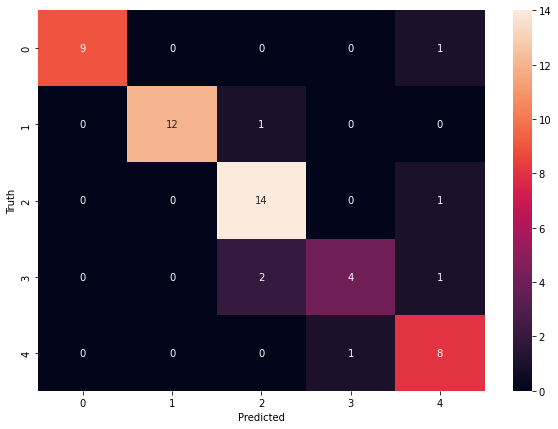

In [28]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [29]:
class_dict

{'barack_obama': 0,
 'bill_clinton': 1,
 'joe_biden': 2,
 'donald_trump': 3,
 'george_w_bush': 4}

In [30]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [31]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))